In [1]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay

from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [3]:
all_hists = []
cat = groupby("category", keeporder=True)

countsLen = Hist(hbin("countsLen", 100, 0, 100000), cat)
all_hists.append(countsLen)
countsDist = Hist(hbin("countsDist", 10, 0, 10), cat)
all_hists.append(countsDist)
entriesLen = Hist(hbin("entriesLen", 100, 0, 100000), cat)
all_hists.append(entriesLen)

electronPt = Hist(hbin("electronPt", 100, 0, 500), cat)
all_hists.append(electronPt)

zMass = Hist(hbin("zMass", 120, 0, 120), cat)
all_hists.append(zMass)

display = IPythonDisplay(
    below(
        beside(
            countsLen.overlay("category").step("countsLen"),
            countsDist.overlay("category").step("countsDist"),
            entriesLen.overlay("category").step("entriesLen"),
        ),
        beside(
            electronPt.overlay("category").step("electronPt"),
            zMass.overlay("category").step("zMass"),
        ),
    )
)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [8]:
#__worker_class__
    

# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))

    
import numpy as np
import awkward
import uproot_methods

def p4_pt(p4):
    return np.hypot(p4.content[:,0], p4.content[:,1])

def p4_minv(p4):
    p4sq = p4**2
    return np.sqrt(p4sq.content[:,3] - np.sum(p4sq.content[:,:3], axis=1))

pt = lambda p4: np.hypot(p4[0]+p4[1])
p4sum = lambda cand: cand['0']['p4']+cand['1']['p4']
metric = np.array([1., 1., 1., -1.])
mass = lambda cand: np.sqrt((cand**2 * metric).sum())

class Worker(object):
    def __init__(self):
        self.Electron_columns = ["Electron.charge", "Electron.p4", "Electron.tightID"]
        self.Columns = self.Electron_columns + []
        
    def run(self, events, job): 
        electrons = awkward.JaggedArray.fromcounts(events.Electron.count, awkward.Table({
            'p4': events.Electron.p4,
            'q': events.Electron.charge,
            'tightID': events.Electron.tightID
        }))
        
        good_electron = electrons['tightID'] > 0
        # in future: member methods
        leading_el = electrons['p4'].maxby(pt)['p4'].apply(pt)
        zcands = electrons[good_electron].pairs(same=False)
        zmass = zcands.apply(lambda cand: mass(p4sum(cand)))
        
        
        # separate fill() calls necessary when array sizes are non-uniform
        job.fill(
            category="all",
            countsLen=len(events.Electron.count),
            countsDist=events.Electron.count,
            entriesLen=len(events.Electron.charge),
        )
        job.fill(
            category="all",
            electronPt=leading_el,
        )
        job.fill(
            category="pass",
            electronPt=leading_el[good_electron],
        )
        job.fill(
            category="pass",
            zMass=zmass.flatten(),
        )


Striped worker #194 excepton:
Traceback (most recent call last):
  File "product/worker/socket_worker_spawner3.py", line 79, in run
    self.runWorker(params, dxsock, addr)
  File "product/worker/socket_worker_spawner3.py", line 121, in runWorker
    nevents = worker.run()
  File "/home/ivm/build/striped/worker/StripedWorker2.py", line 155, in run
    sandbox_call(worker.run, event_group, job_interface)
  File "/home/ivm/build/striped/worker/sandbox.py", line 37, in sandbox_call
    return func(*params, **args)
  File "/tmp/wm_6830b946-ed03-11e8-b19f-00259049645c_31940.py", line 42, in run
    leading_el = electrons['p4'].maxby(pt)['p4'].apply(pt)
  File "/home/ivm/.local/lib/python2.7/site-packages/awkward/array/base.py", line 185, in maxby
    return self[function(self).argmax()]
  File "/tmp/wm_6830b946-ed03-11e8-b19f-00259049645c_31940.py", line 23, in <lambda>
    pt = lambda p4: np.hypot(p4[0]+p4[1])
ValueError: invalid number of arguments

Striped worker #5 excepton:
Traceback (

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8          0.000 M events,   0.000 M events/sec


Total events processed: 0 in 0.4 seconds -> 0.000000 million events/second


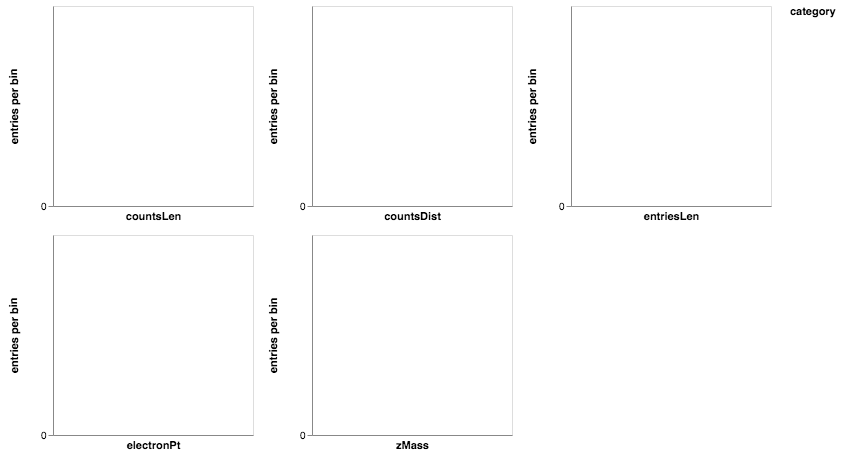

In [9]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists)

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=0.1,
            user_callback=callback, 
            # user_params = {"category":category},
            histograms=all_hists
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)
